In [1]:
import multiprocessing
from multiprocessing.pool import ThreadPool
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from skimage import io, transform, feature,color
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
labels = pd.read_csv('DATASET/train.csv')
dir_ = os.path.join('DATASET/images/') 
labels['file_path'] = labels['id_code'].map(lambda x:os.path.join(dir_,'{}.png'.format(x)))
labels['file_name'] = labels['id_code'].apply(lambda x: x + ".png")
labels['diagnosis'] = labels['diagnosis'].astype(str)

In [3]:
print(labels.shape)
print(labels.head())

(3662, 4)
        id_code diagnosis                        file_path         file_name
0  000c1434d8d7         2  DATASET/images/000c1434d8d7.png  000c1434d8d7.png
1  001639a390f0         4  DATASET/images/001639a390f0.png  001639a390f0.png
2  0024cdab0c1e         1  DATASET/images/0024cdab0c1e.png  0024cdab0c1e.png
3  002c21358ce6         0  DATASET/images/002c21358ce6.png  002c21358ce6.png
4  005b95c28852         0  DATASET/images/005b95c28852.png  005b95c28852.png


In [4]:
# Resize the images and stores in given directory
def resize_image(file):
    img_size = 512
    input_ = os.path.join('DATASET/images','{}.png'.format(file))
    output_ = os.path.join('DATASET/images_resized','{}.png'.format(file))
    img = cv2.imread(input_)
    return cv2.imwrite(output_, cv2.resize(img, (img_size,img_size)))

In [5]:
# Applying Multi processing techniques to save images faster
def multiprocess_image_downloader(process:int, imgs:list):
    results = ThreadPool(process).map(resize_image, imgs)
    return results

In [6]:
# Using 6 cores
multiprocess_image_downloader(6, list(labels.id_code.values))

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [7]:
#Preprocessing images by performing Gaussian Blur and Circle Crop
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark, we crop out everything
            return img # returns original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [17]:
def circle_crop(img, sigmaX=30):   
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [18]:
def preprocess_image(file):
    input_filepath = os.path.join('DATASET/images_resized/','{}.png'.format(file))
    output_filepath = os.path.join('DATASET/processed_images/','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    img = circle_crop(img)
    return cv2.imwrite(output_filepath, cv2.resize(img, (512,512)))

In [19]:
#This Function uses Multi processing for faster saving of images into folder
def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [20]:
multiprocess_image_processor(6, list(labels.id_code.values))

MESSAGE: Running 6 process


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [103]:
#This Function generates 'lim' number of Image Augmentations from a random Image in the directory
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df.file_path.iloc[np.random.randint(low = 0,high = len(df) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512,512))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    img_arr = img.reshape((1,) + img.shape)
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

In [240]:
image_dir = 'DATASET/processed_images'
num_images_per_class = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for index, row in df.iterrows():
    class_label = row['diagnosis']
    num_images_per_class[class_label] += 1
print(num_images_per_class)

{0: 1805, 1: 370, 2: 999, 3: 193, 4: 295}


In [242]:
image_dir = 'DATASET/processed_images'
# number of images you want to generate per class
num_images_required = [1, 1805-370, 1805-999, 1805-193, 1805-295]

# Create a directory to store augmented images
if not os.path.exists(os.path.join(image_dir, 'augmented')):
    os.makedirs(os.path.join(image_dir, 'augmented'))

for class_label in num_images_per_class.keys():
    class_dir = os.path.join(image_dir, 'augmented', str(class_label))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    image_paths = df[df['diagnosis'] == class_label]['file_path'].values
    datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

    # Generate the required number of images 
    for i in range(num_images_required[class_label]):
        image_path = image_paths[i % len(image_paths)]
        image = load_img(image_path, target_size=(512,512))
        image = img_to_array(image)
        image = image.reshape((1,) + image.shape)
        augmented_images = datagen.flow(image, save_to_dir=class_dir,
                                          save_format='png')
        for batch in augmented_images:
            break 

In [243]:
# Number of images in each class after augmentation
for class_label in range(len(num_images_required)):
    num_images = len(os.listdir(os.path.join(image_dir, 'augmented', str(class_label))))
    print(f"Class {class_label}: {num_images} images after augmentation")

Class 0: 1 images after augmentation
Class 1: 1336 images after augmentation
Class 2: 770 images after augmentation
Class 3: 1485 images after augmentation
Class 4: 1388 images after augmentation


In [250]:
directory = "DATASET/processed_images/augmented"
with open('image_labels.csv', mode='w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id_code','file_path', 'diagnosis'])
    for subdir in os.listdir(directory):
        subfolder = os.path.join(directory, subdir)
        if os.path.isdir(subfolder):
            for filename in os.listdir(subfolder):
                img_path = os.path.join(subfolder, filename)
                writer.writerow([filename,img_path, subdir])


In [21]:
df1 = pd.read_csv('DATASET/train.csv')
dir_1 = os.path.join('./','DATASET/processed_images/')
df1['file_path'] = df1['id_code'].map(lambda x: os.path.join(dir_1,'{}.png'.format(x)))
df1['file_name'] = df1["id_code"] + ".png"

In [22]:
df2 = pd.read_csv('DATASET/image_labels.csv')
dir_2 = os.path.join('./', 'DATASET/processed_images/augmented/')
df2['file_name'] = df2['id_code'] 

In [23]:
merged_df = pd.concat([df1, df2], axis=0)
merged_df.to_csv('merged_file.csv', index=False)

In [24]:
merged_df.head()

,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./DATASET/processed_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./DATASET/processed_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./DATASET/processed_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./DATASET/processed_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./DATASET/processed_images/005b95c28852.png,005b95c28852.png


In [25]:
X = []
y = []
for index, row in merged_df.iterrows():
    image = io.imread(row['file_path'])
    if image.shape[0] != 256 or image.shape[1] != 256:
        image = transform.resize(image, (256, 256))
    image = color.rgb2gray(image)
    image = image.astype('float32') / 255.0
    lbp = feature.local_binary_pattern(image, P=8, R=1)
    hist, _ = np.histogram(lbp, bins=512)
    X.append(hist)
    y.append(row['diagnosis'])
X = np.array(X)
y = np.array(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=51,shuffle=True)

In [27]:
#NaiveBayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

In [28]:
#K-nearest neigbours
knn = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree',leaf_size=30)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

In [30]:
#Decision Trees
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

In [31]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [32]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)

In [33]:
#Support Vector Machines
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

In [34]:
#XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

In [35]:
#CatBoost
catboost_model = CatBoostClassifier(random_state=42)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
acc_catboost = accuracy_score(y_test, y_pred_catboost)

Learning rate set to 0.087327
0:	learn: 1.5508860	total: 238ms	remaining: 3m 57s
1:	learn: 1.5014665	total: 266ms	remaining: 2m 12s
2:	learn: 1.4632798	total: 292ms	remaining: 1m 37s
3:	learn: 1.4290442	total: 320ms	remaining: 1m 19s
4:	learn: 1.3994676	total: 346ms	remaining: 1m 8s
5:	learn: 1.3743033	total: 372ms	remaining: 1m 1s
6:	learn: 1.3494146	total: 399ms	remaining: 56.5s
7:	learn: 1.3322700	total: 423ms	remaining: 52.4s
8:	learn: 1.3131787	total: 449ms	remaining: 49.4s
9:	learn: 1.2979751	total: 475ms	remaining: 47s
10:	learn: 1.2836273	total: 501ms	remaining: 45.1s
11:	learn: 1.2698757	total: 527ms	remaining: 43.4s
12:	learn: 1.2568958	total: 551ms	remaining: 41.9s
13:	learn: 1.2471950	total: 576ms	remaining: 40.6s
14:	learn: 1.2358033	total: 603ms	remaining: 39.6s
15:	learn: 1.2275764	total: 630ms	remaining: 38.7s
16:	learn: 1.2182513	total: 656ms	remaining: 37.9s
17:	learn: 1.2091247	total: 683ms	remaining: 37.3s
18:	learn: 1.2041639	total: 708ms	remaining: 36.6s
19:	learn

163:	learn: 0.9065304	total: 4.41s	remaining: 22.5s
164:	learn: 0.9050681	total: 4.43s	remaining: 22.4s
165:	learn: 0.9039215	total: 4.46s	remaining: 22.4s
166:	learn: 0.9026256	total: 4.48s	remaining: 22.4s
167:	learn: 0.9013120	total: 4.51s	remaining: 22.3s
168:	learn: 0.9006156	total: 4.53s	remaining: 22.3s
169:	learn: 0.8988720	total: 4.55s	remaining: 22.2s
170:	learn: 0.8976996	total: 4.58s	remaining: 22.2s
171:	learn: 0.8965846	total: 4.61s	remaining: 22.2s
172:	learn: 0.8953284	total: 4.63s	remaining: 22.1s
173:	learn: 0.8939772	total: 4.66s	remaining: 22.1s
174:	learn: 0.8927484	total: 4.68s	remaining: 22.1s
175:	learn: 0.8925701	total: 4.7s	remaining: 22s
176:	learn: 0.8917859	total: 4.73s	remaining: 22s
177:	learn: 0.8912794	total: 4.75s	remaining: 21.9s
178:	learn: 0.8906376	total: 4.77s	remaining: 21.9s
179:	learn: 0.8887244	total: 4.8s	remaining: 21.9s
180:	learn: 0.8876270	total: 4.82s	remaining: 21.8s
181:	learn: 0.8857355	total: 4.84s	remaining: 21.8s
182:	learn: 0.8843

322:	learn: 0.7504172	total: 8.39s	remaining: 17.6s
323:	learn: 0.7493901	total: 8.42s	remaining: 17.6s
324:	learn: 0.7477549	total: 8.44s	remaining: 17.5s
325:	learn: 0.7468399	total: 8.47s	remaining: 17.5s
326:	learn: 0.7458685	total: 8.49s	remaining: 17.5s
327:	learn: 0.7453946	total: 8.51s	remaining: 17.4s
328:	learn: 0.7448913	total: 8.54s	remaining: 17.4s
329:	learn: 0.7436735	total: 8.56s	remaining: 17.4s
330:	learn: 0.7427478	total: 8.59s	remaining: 17.4s
331:	learn: 0.7419297	total: 8.61s	remaining: 17.3s
332:	learn: 0.7410144	total: 8.64s	remaining: 17.3s
333:	learn: 0.7403494	total: 8.66s	remaining: 17.3s
334:	learn: 0.7394671	total: 8.69s	remaining: 17.3s
335:	learn: 0.7386749	total: 8.72s	remaining: 17.2s
336:	learn: 0.7383470	total: 8.74s	remaining: 17.2s
337:	learn: 0.7378888	total: 8.76s	remaining: 17.2s
338:	learn: 0.7367331	total: 8.79s	remaining: 17.1s
339:	learn: 0.7361193	total: 8.81s	remaining: 17.1s
340:	learn: 0.7359259	total: 8.84s	remaining: 17.1s
341:	learn: 

489:	learn: 0.6304482	total: 12.6s	remaining: 13.1s
490:	learn: 0.6296516	total: 12.6s	remaining: 13.1s
491:	learn: 0.6290618	total: 12.6s	remaining: 13s
492:	learn: 0.6283420	total: 12.7s	remaining: 13s
493:	learn: 0.6275026	total: 12.7s	remaining: 13s
494:	learn: 0.6269204	total: 12.7s	remaining: 13s
495:	learn: 0.6261091	total: 12.7s	remaining: 12.9s
496:	learn: 0.6254632	total: 12.8s	remaining: 12.9s
497:	learn: 0.6250508	total: 12.8s	remaining: 12.9s
498:	learn: 0.6245601	total: 12.8s	remaining: 12.9s
499:	learn: 0.6241122	total: 12.8s	remaining: 12.8s
500:	learn: 0.6239083	total: 12.9s	remaining: 12.8s
501:	learn: 0.6231985	total: 12.9s	remaining: 12.8s
502:	learn: 0.6228049	total: 12.9s	remaining: 12.8s
503:	learn: 0.6219474	total: 12.9s	remaining: 12.7s
504:	learn: 0.6212939	total: 13s	remaining: 12.7s
505:	learn: 0.6207036	total: 13s	remaining: 12.7s
506:	learn: 0.6200517	total: 13s	remaining: 12.6s
507:	learn: 0.6194758	total: 13s	remaining: 12.6s
508:	learn: 0.6187015	total:

649:	learn: 0.5467507	total: 16.6s	remaining: 8.92s
650:	learn: 0.5455933	total: 16.6s	remaining: 8.9s
651:	learn: 0.5449623	total: 16.6s	remaining: 8.87s
652:	learn: 0.5444086	total: 16.7s	remaining: 8.86s
653:	learn: 0.5437007	total: 16.7s	remaining: 8.83s
654:	learn: 0.5430165	total: 16.7s	remaining: 8.8s
655:	learn: 0.5427896	total: 16.7s	remaining: 8.78s
656:	learn: 0.5423609	total: 16.8s	remaining: 8.75s
657:	learn: 0.5421864	total: 16.8s	remaining: 8.72s
658:	learn: 0.5417629	total: 16.8s	remaining: 8.7s
659:	learn: 0.5412651	total: 16.8s	remaining: 8.67s
660:	learn: 0.5410923	total: 16.9s	remaining: 8.65s
661:	learn: 0.5409245	total: 16.9s	remaining: 8.62s
662:	learn: 0.5404470	total: 16.9s	remaining: 8.59s
663:	learn: 0.5399175	total: 16.9s	remaining: 8.57s
664:	learn: 0.5393732	total: 17s	remaining: 8.54s
665:	learn: 0.5392802	total: 17s	remaining: 8.52s
666:	learn: 0.5390700	total: 17s	remaining: 8.49s
667:	learn: 0.5389610	total: 17s	remaining: 8.46s
668:	learn: 0.5388755	t

810:	learn: 0.4772549	total: 20.7s	remaining: 4.82s
811:	learn: 0.4768928	total: 20.7s	remaining: 4.8s
812:	learn: 0.4762562	total: 20.7s	remaining: 4.77s
813:	learn: 0.4762007	total: 20.8s	remaining: 4.75s
814:	learn: 0.4759773	total: 20.8s	remaining: 4.72s
815:	learn: 0.4756261	total: 20.8s	remaining: 4.7s
816:	learn: 0.4751417	total: 20.8s	remaining: 4.67s
817:	learn: 0.4748282	total: 20.9s	remaining: 4.64s
818:	learn: 0.4741933	total: 20.9s	remaining: 4.62s
819:	learn: 0.4737087	total: 20.9s	remaining: 4.59s
820:	learn: 0.4733488	total: 20.9s	remaining: 4.57s
821:	learn: 0.4730829	total: 21s	remaining: 4.54s
822:	learn: 0.4728024	total: 21s	remaining: 4.51s
823:	learn: 0.4725652	total: 21s	remaining: 4.49s
824:	learn: 0.4724795	total: 21s	remaining: 4.46s
825:	learn: 0.4722517	total: 21.1s	remaining: 4.44s
826:	learn: 0.4720473	total: 21.1s	remaining: 4.41s
827:	learn: 0.4715936	total: 21.1s	remaining: 4.38s
828:	learn: 0.4712516	total: 21.1s	remaining: 4.36s
829:	learn: 0.4710488	

972:	learn: 0.4173491	total: 24.7s	remaining: 686ms
973:	learn: 0.4170245	total: 24.7s	remaining: 660ms
974:	learn: 0.4164866	total: 24.8s	remaining: 635ms
975:	learn: 0.4160555	total: 24.8s	remaining: 610ms
976:	learn: 0.4157640	total: 24.8s	remaining: 584ms
977:	learn: 0.4154390	total: 24.8s	remaining: 559ms
978:	learn: 0.4151565	total: 24.9s	remaining: 533ms
979:	learn: 0.4147933	total: 24.9s	remaining: 508ms
980:	learn: 0.4143973	total: 24.9s	remaining: 483ms
981:	learn: 0.4140945	total: 24.9s	remaining: 457ms
982:	learn: 0.4137685	total: 25s	remaining: 432ms
983:	learn: 0.4134997	total: 25s	remaining: 406ms
984:	learn: 0.4132938	total: 25s	remaining: 381ms
985:	learn: 0.4128057	total: 25s	remaining: 356ms
986:	learn: 0.4123390	total: 25.1s	remaining: 330ms
987:	learn: 0.4117854	total: 25.1s	remaining: 305ms
988:	learn: 0.4115369	total: 25.1s	remaining: 279ms
989:	learn: 0.4112391	total: 25.1s	remaining: 254ms
990:	learn: 0.4106707	total: 25.2s	remaining: 229ms
991:	learn: 0.410363

In [36]:
#AdaBoost
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_estimator=base_model, random_state=42)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)
acc_adaboost = accuracy_score(y_test, y_pred_adaboost)

In [37]:
print(f'Naive Bayes test accuracy:{acc_nb*100:.2f}')
print(f'KNN test accuracy:{acc_knn*100:.2f}')
print(f'SVM test accuracy:{acc_svm*100:.2f}')
print(f'Decision tree test accuracy:{acc_dt*100:.2f}')
print(f'Random forest test accuracy:{acc_rf*100:.2f}')
print(f'Gradiet boosting test accuracy:{acc_gb*100:.2f}')
print(f'XGBoost test accuracy:{acc_xgb*100:.2f}')
print(f'CatBoost test accuracy:{acc_catboost*100:.2f}')
print(f'AdaBoost test accuracy:{acc_adaboost*100:.2f}')

Naive Bayes test accuracy:41.35
KNN test accuracy:46.79
SVM test accuracy:48.12
Decision tree test accuracy:43.20
Random forest test accuracy:55.12
Gradiet boosting test accuracy:55.00
XGBoost test accuracy:56.28
CatBoost test accuracy:56.85
AdaBoost test accuracy:45.92


In [101]:
#Artificial Neural Networks
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(256,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
217/217 [==============================] - 1s 908us/step - loss: 66.8187 - accuracy: 0.3282
Epoch 2/100
217/217 [==============================] - 0s 879us/step - loss: 21.4844 - accuracy: 0.3823
Epoch 3/100
217/217 [==============================] - 0s 954us/step - loss: 17.9498 - accuracy: 0.3953
Epoch 4/100
217/217 [==============================] - 0s 852us/step - loss: 14.8080 - accuracy: 0.4014
Epoch 5/100
217/217 [==============================] - 0s 861us/step - loss: 9.7855 - accuracy: 0.4201
Epoch 6/100
217/217 [==============================] - 0s 852us/step - loss: 12.5114 - accuracy: 0.3992
Epoch 7/100
217/217 [==============================] - 0s 851us/step - loss: 9.7685 - accuracy: 0.4238
Epoch 8/100
217/217 [==============================] - 0s 858us/step - loss: 11.4971 - accuracy: 0.4302
Epoch 9/100
217/217 [==============================] - 0s 917us/step - loss: 8.8393 - accuracy: 0.4296
Epoch 10/100
217/217 [==============================] - 0s 933us/st

55/55 [==============================] - 0s 659us/step
Test Accuracy: 41.70%


Text(70.72222222222221, 0.5, 'True Labels')

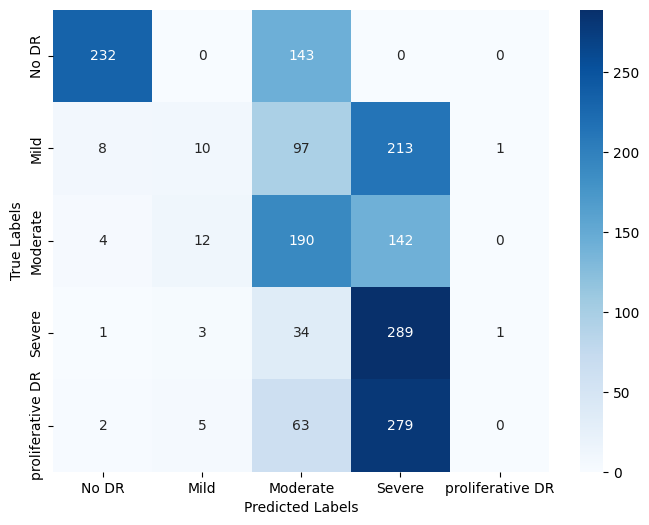

In [102]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predicted_labels)
print("Test Accuracy: %.2f%%" % (accuracy * 100))
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["No DR", "Mild", "Moderate","Severe","proliferative DR"], yticklabels=["No DR", "Mild", "Moderate","Severe","proliferative DR"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

In [29]:
def image_generator(data, batch_size=32,validation=False):
    num_samples = len(data)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    while True:
        for start_idx in range(0, num_samples - batch_size + 1, batch_size):
            excerpt = indices[start_idx:start_idx + batch_size]
            images = []
            labels = []
            for idx in excerpt:
                row = data.iloc[idx]
                image = cv2.imread(row['file_path'])
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                
                images.append(image)
                labels.append(row['diagnosis'])
            
            if validation:
                yield np.array(images), np.array(labels)
            else:
                yield np.array(images), np.array(labels)
            

In [30]:
train_data, test_data = train_test_split(merged_df, test_size=0.2, random_state=42,shuffle=True)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42,shuffle=True)
train_generator = image_generator(train_data, batch_size=32)
validation_generator = image_generator(valid_data, batch_size=32, validation=True)
test_generator = image_generator(test_data, batch_size=32)

In [13]:
#CNN model with dropouts and l2 regulizers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3),
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [32]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_data) // 16)
print('Test accuracy:', test_acc)

108/108 [==============================] - 255s 2s/step - loss: 0.8790 - accuracy: 0.6516
Test accuracy: 0.6516203880310059
